In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%cd "/content/gdrive/MyDrive/deep_learning_project/"
!pip install import-ipynb

/content/gdrive/.shortcut-targets-by-id/1qVgfaA1yUyO3mfj4iQgBT95M8G5EAF0v/deep_learning_project
  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-cp37-none-any.whl size=2976 sha256=527fd5a2e31c91038eeb46995e8d54d3bf4d09a545c123ebf436531f34561865
  Stored in directory: /root/.cache/pip/wheels/b4/7b/e9/a3a6e496115dffdb4e3085d0ae39ffe8a814eacc44bbf494b5
Successfully built import-ipynb


In [3]:
'''
print(training_labels[:20])
baseline_0 = training_images[0]
visualize_image(baseline_0,"baseline")
abnormaly_0 = training_images[1]
visualize_image(abnormaly_0,"abnormaly")
'''
#>>> array([0, 2, 0, 2, 0, 1, 0, 1, 0, 1])

'\nprint(training_labels[:20])\nbaseline_0 = training_images[0]\nvisualize_image(baseline_0,"baseline")\nabnormaly_0 = training_images[1]\nvisualize_image(abnormaly_0,"abnormaly")\n'

# IMAGE LOADING AND DATASET SAVING

importing Jupyter notebook from utils.ipynb


/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


------------------------------------------------
original distribution


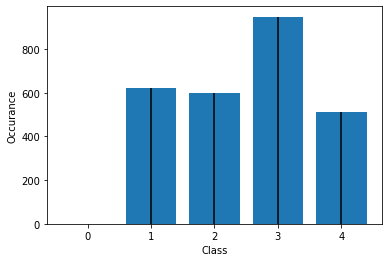

------------------------------------------------
testing set


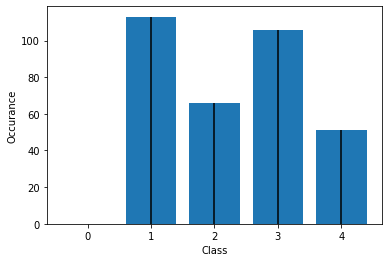

In [4]:
import import_ipynb
from utils import *
from PIL import Image, ImageEnhance
import tensorflow as tf
from sklearn.utils import shuffle

training_images, training_labels = load_training()
testing_images, testing_labels = load_testing()
labels_distribution(training_labels,"original distribution")
labels_distribution(testing_labels,"testing set")


------------------------------------------------
traducted distribution


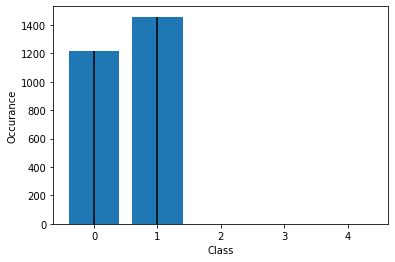

------------------------------------------------
testing set


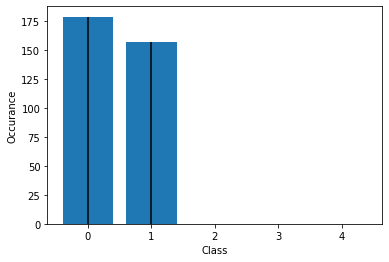

(2676, 150, 150)


In [5]:
training_labels = label_traduction(training_labels,1)
testing_labels = label_traduction(testing_labels,1)
labels_distribution(training_labels,"traducted distribution")
labels_distribution(testing_labels,"testing set")
print(np.shape(training_images))

Oversampling on label 0
------------------------------------------------
oversampled distribution


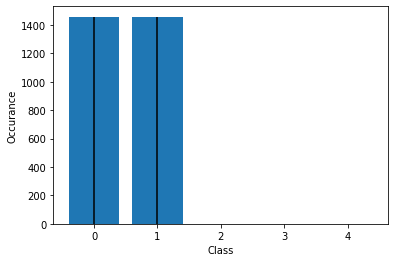

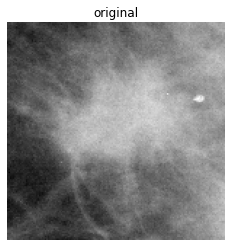

In [6]:
training_images, training_labels = oversample(training_images,training_labels)
labels_distribution(training_labels,"oversampled distribution")
visualize_image(training_images[0],"original")

------------------------------------------------
oversampled distribution shuffled


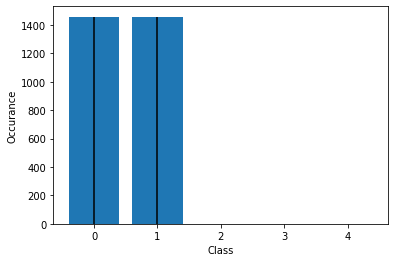

In [7]:
training_images,training_labels = shuffle_data(training_images,training_labels)
labels_distribution(training_labels,"oversampled distribution shuffled")

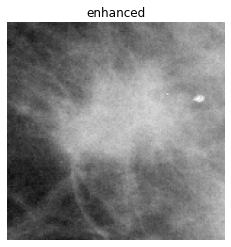

In [8]:
training_images = enhance_contrast(training_images)
testing_images = enhance_contrast(testing_images)

#training_images = enhance_image(training_images)
#testing_images = enhance_image(testing_images)
visualize_image(training_images[0],"enhanced")

# Dataset importing

In [9]:
import tensorflow as tf
TRAIN_DATA_DIR = "/content/gdrive/MyDrive/deep_learning_project/dataset/2.1/train"
TEST_DATA_DIR = "/content/gdrive/MyDrive/deep_learning_project/dataset/2.1/test"
BATCH_SIZE = 50
NORMALIZATION = 65536

In [10]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./NORMALIZATION)

'''
train_datagen = ImageDataGenerator(
    rescale=1./NORMALIZATION,
    #rotation_range=40,
    rotation_range=90,
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    #shear_range=20,
    #zoom_range=0.2,
    #horizontal_flip=True,
    )
'''

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./NORMALIZATION)


#training_images = np.expand_dims(training_images, -1)
#testing_images = np.expand_dims(testing_images, -1)

training_images = np.expand_dims(training_images, 3)
testing_images = np.expand_dims(testing_images, 3)

splitted_train_images, splitted_val_images, splitted_train_labels, splitted_val_labels = train_test_split(training_images, training_labels, test_size=0.3, stratify=training_labels)


train_generator = train_datagen.flow(splitted_train_images, 
                                     y=splitted_train_labels, 
                                     batch_size=BATCH_SIZE, 
                                     seed=123)

validation_generator = train_datagen.flow(splitted_val_images, 
                                          y=splitted_val_labels, 
                                          batch_size=BATCH_SIZE, 
                                          seed=123)

test_generator =  test_datagen.flow(testing_images,
                                    y=testing_labels,
                                    batch_size=BATCH_SIZE,
                                    seed=123)

# CNN Model Construction

# Model Compile

In [11]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import models,layers

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

conv_base.summary()

conv_base.trainable=False

#conv_base = Model(inputs=conv_base.input, outputs=conv_base.get_layer('block5_pool').output)
#conv_base.summary()


58892288/58889256 [==============================] - 2s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
______________________________________________________________

In [12]:
model = models.Sequential()
model.add(tf.keras.Input(shape=(150,150,1)))
model.add(layers.experimental.preprocessing.RandomFlip(mode='horizontal', seed=123))
model.add(layers.experimental.preprocessing.RandomRotation(factor=0.25, seed=123, fill_mode='nearest'))
model.add(layers.Conv2D(3,(1,1),activation = 'relu')) # to transform grayscale to rgb images
model.add(conv_base)
model.add(layers.Flatten())
#model.add(layers.Dropout(0.2))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

#model.summary()

In [13]:
import tensorflow as tf
from tensorflow.keras import optimizers


model.compile(loss='binary_crossentropy',
              optimizer = optimizers.Adam(learning_rate=0.003),
              #optimizer='adam',
              metrics=['accuracy'])


# Model Fitting

In [14]:
EPOCHS = 15

history = model.fit(
    train_generator, 
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    validation_data = validation_generator,
    )

Epoch 1/15
41/41 [==============================] - 71s 810ms/step - loss: 1.0611 - accuracy: 0.5551 - val_loss: 0.6055 - val_accuracy: 0.6811
Epoch 2/15
41/41 [==============================] - 22s 528ms/step - loss: 0.5614 - accuracy: 0.7178 - val_loss: 0.5046 - val_accuracy: 0.8103
Epoch 3/15
41/41 [==============================] - 22s 533ms/step - loss: 0.4735 - accuracy: 0.7785 - val_loss: 0.4384 - val_accuracy: 0.8171
Epoch 4/15
41/41 [==============================] - 22s 540ms/step - loss: 0.4300 - accuracy: 0.8011 - val_loss: 0.4325 - val_accuracy: 0.8080
Epoch 5/15
41/41 [==============================] - 22s 542ms/step - loss: 0.4161 - accuracy: 0.8040 - val_loss: 0.3934 - val_accuracy: 0.8366
Epoch 6/15
41/41 [==============================] - 22s 543ms/step - loss: 0.3550 - accuracy: 0.8486 - val_loss: 0.4759 - val_accuracy: 0.7589
Epoch 7/15
41/41 [==============================] - 22s 543ms/step - loss: 0.3456 - accuracy: 0.8584 - val_loss: 0.3615 - val_accuracy: 0.8491

#Model Saving

In [15]:
import pickle
path = "/content/gdrive/MyDrive/deep_learning_project/models/3.1/"
model_name = "VGG16"
model.save( path + model_name + ".h5")
with open(path + model_name + "_history.pickle", 'wb') as file_pi:
        pickle.dump(history.history,  file_pi)

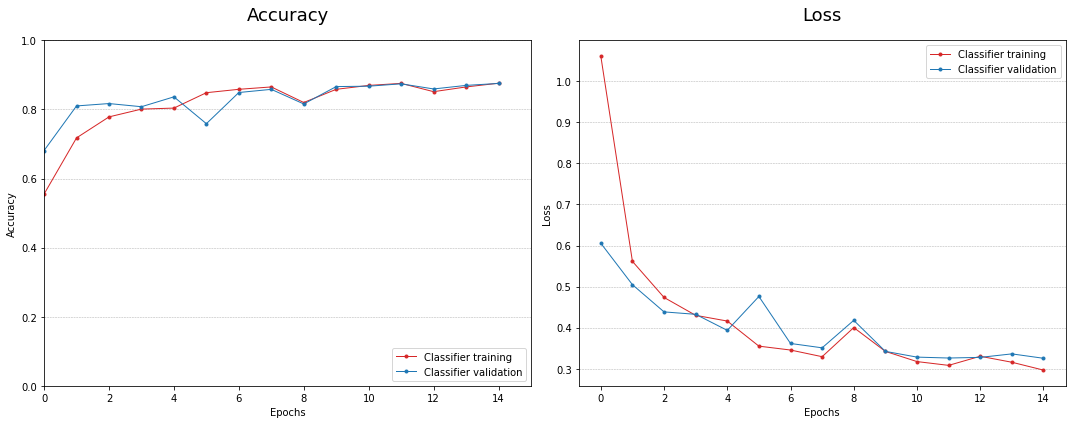

In [16]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# create figure
fig, (acc_g,loss_g) = plt.subplots(1,2, figsize=(15,6))

# range for x axis
epochs = range(len(acc))

# plot accuracy curves
acc_g.axis([0,15,0,1])
acc_g.plot(epochs, acc, color='tab:red', marker='.', linestyle='-', label='Classifier training', linewidth=1)
acc_g.plot(epochs, val_acc, color='tab:blue', marker='.', linestyle='-', label='Classifier validation', linewidth=1)

# plot loss curves

loss_g.plot(epochs, loss, color='tab:red', marker='.', linestyle='-', label='Classifier training ', linewidth=1)
loss_g.plot(epochs, val_loss, color='tab:blue', marker='.', linestyle='-', label='Classifier validation', linewidth=1)

# accuracy graph style options
acc_g.grid(axis='y', linestyle='--', linewidth=0.5)
acc_g.set_xlabel('Epochs')
acc_g.set_ylabel('Accuracy')
acc_g.set_title('Accuracy', fontdict={'fontsize':18}, pad=20)
acc_g.legend(loc='lower right')

# loss graph style options
loss_g.grid(axis='y', linestyle='--', linewidth=0.5)
loss_g.set_xlabel('Epochs')
loss_g.set_ylabel('Loss')
loss_g.set_title('Loss', fontdict={'fontsize':18}, pad=20)
loss_g.legend(loc='upper right')

# layout adjustment
plt.tight_layout()

In [17]:
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test loss", test_loss)
print("Test accuracy",test_accuracy)

7/7 [==============================] - 7s 1s/step - loss: 0.3576 - accuracy: 0.8363
Test loss 0.35758358240127563
Test accuracy 0.836309552192688


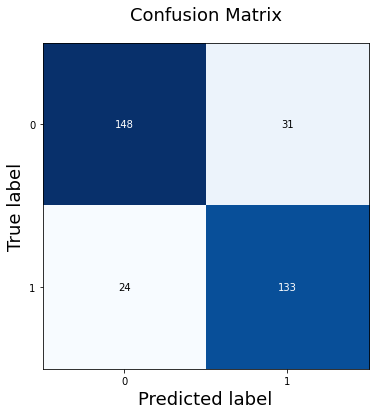

precision score:  0.8109756097560976
recall score:  0.8471337579617835
f2:  0.8396464646464645
f0.5:  0.8179581795817958
classification report: 
               precision    recall  f1-score   support

           0       0.86      0.83      0.84       179
           1       0.81      0.85      0.83       157

    accuracy                           0.84       336
   macro avg       0.84      0.84      0.84       336
weighted avg       0.84      0.84      0.84       336

AUC:  0.8369747002099421


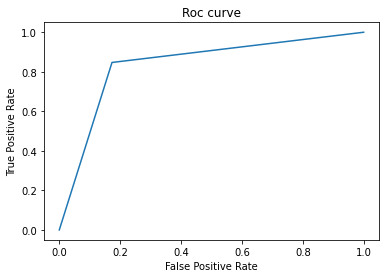

In [18]:
prediction = model.predict(testing_images/65536)
in_depth_performance(testing_labels,np.where(prediction > 0.5, 1,0)) #np.where is used to conver from probability to binary label